In [2]:
import numpy as np

from engine import RMG, AdvRw
from agent import RandomAgent, IndQLearningAgent, FPLearningAgent, FPQwForgetAgent, Level2QAgent

In [37]:
possible_actions = [0, 1]  # Target A or B
gamma = 0.  # only one steps!


rw_agents = []
agents = [IndQLearningAgent, FPQwForgetAgent, Level2QAgent]


for agent in agents:
    
    print('Beginning experiments with agent ', agent.__name__)

    N_EXP = 20

    r0ss = []

    smooth = 100

    for n in range(N_EXP):
        batch_size = 1
        max_steps = 1

        mode = 'adversary'
        env = AdvRw(mode, p=0.6)  # p is only used in neutral mode
        env.reset()

        p = agent(possible_actions, enemy_action_space=possible_actions, n_states=1, learning_rate=0.1, epsilon=0.1, gamma=gamma)

        # Stateless interactions (agents do not have memory)
        s = 0

        n_iter = 1000 + smooth # because of the smoothening in the graphics

        r0s = []
        r1s = []

        for i in range(n_iter):

            # A full episode:
            done = False

            while not done:

                # Agents decide
                a0 = p.act()

                # World changes
                _, (r0, _), done, _ = env.step(a0)

                # Agents learn
                if r0 > 0: # p was correct
                    a1 = a0
                else:
                    a1 = 1 - a0
    
                #r1 = -r0
                r1 = float(r0 < 0) #- 1
                #r1 = float(r0 < 0) - 1
                #r1 = float(r0 < 0)*0.05
                p.update(s, (a0, a1), (r0, r1) , s )

                #s = new_s  #stateless!

                r0s.append(r0)

            env.reset()

        r0ss.append(r0s)
        
    rw_agents.append(r0ss)

Beginning experiments with agent  IndQLearningAgent
Beginning experiments with agent  FPQwForgetAgent
Beginning experiments with agent  Level2QAgent


In [38]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

We report moving avearage of rewards, since it's common in RL taks

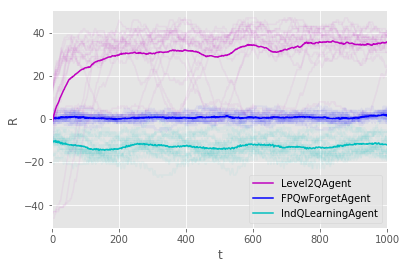

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# We set a fancy theme
plt.style.use('ggplot')

colors = 'cbm'
plt.axis([0, max_steps*n_iter - smooth, -50.5, 50.5])
for j,a in enumerate(agents):
    r0ss = rw_agents[j]
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 100), colors[j], alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 100), colors[j], alpha=1)

plt.xlabel('t');
plt.ylabel('R');

from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color=colors[::-1][i]) for i,_ in enumerate(agents)]

plt.legend(custom_lines,[a.__name__ for a in reversed(agents)], loc=4);

plt.savefig('img/4C_binary' + mode + '.png')

For the adversary case (no forget):

In [6]:
moving_average(np.asarray(rw_agents[-1]).mean(axis=0), 100).mean()

31.152897102897107

In [7]:
moving_average(np.asarray(rw_agents[-2]).mean(axis=0), 100).mean()

0.6262237762237763

In [8]:
moving_average(np.asarray(rw_agents[-3]).mean(axis=0), 100).mean()

-11.497252747252746